In [7]:
from pathlib import Path
import re
import pickle
import numpy as np
import xarray as xr
import pandas as pd
import torch
from tqdm.auto import tqdm
import torchlens as tl

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sns.set_palette("Set2")

sns.set_theme(
    context="paper",
    style="white",
    rc={
        "figure.dpi": 600, "savefig.dpi": 600,
        "savefig.bbox": "tight",
        "figure.labelsize": "small",
    }
)

import os
from dotenv import load_dotenv
load_dotenv()

from lib.utils.binning import *
from lib.analyses.yield_models import yield_models, load_yielder
from bonner.caching import BONNER_CACHING_HOME

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered')
warnings.filterwarnings('ignore', category=RuntimeWarning, message='Mean of empty slice')
warnings.filterwarnings('ignore', category=UserWarning, message='Log scale')

Help functions

In [11]:
root = BONNER_CACHING_HOME / "summary_results"

def _yielder_id(idx=0, label=False):
    if not label:
        l = [
            "demo_resnet18_varied_seeds",
        ]
    else:
        l = [
            "Different initializations",
        ]
    if isinstance(idx, int):
        return l[idx]
    else:
        return [l[i] for i in idx]

def _relative_node_depths():
    path = Path(f"{os.getcwd()}/node_depth_dicts/demo.pkl")
    if path.exists():
        return
    yield_id = _yielder_id(idx=0)
    dct = {}
    yielder = load_yielder(yield_id)
    x = torch.rand(2, 3, 224, 224)
    for model in tqdm(yield_models(yielder), desc="model", leave=False):
        architecture = model.identifier.split(".")[0]
        if architecture in dct.keys():
            continue
        dct[architecture] = {}
        model_history = tl.log_forward_pass(model.model, x, layers_to_save=None)
        for node in model.nodes:
            tnode = node
            key_index = 0
            while len(tnode.split(".")) > 0:
                if len(model_history.module_layers[tnode]) > 0:
                    break
                else:
                    try:
                        match = re.search(r'[\W_]\d+$', tnode)
                        key_index = int(re.split(r'[\W_]', tnode)[-1])
                    except:
                        match = re.search(r'[\W]\w+$', node)
                    tnode = tnode[:match.start()]
            dct[architecture][node] = float(model_history.module_layers[tnode][key_index].split("_")[-1])/model_history.num_operations
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(dct, f,)

def _add_node_depths(df):
    _relative_node_depths()
    path = f"{os.getcwd()}/node_depth_dicts/demo.pkl"
    with open(path, "rb") as f:
        dct = pickle.load(f,)
    df["node_depth"] = [dct[df.model.iloc[i].split(".")[0]][df.node.iloc[i]] for i in range(len(df))]
    return df

def _load_main_results(yield_idx, basis, mode, roi="general", reg="ridgecv", individual_subj=False,):
    mode_dict = {"NSD": "shared", "NSD.shared": "same", "RP": "RP",}
    if isinstance(yield_idx, int):
        yield_idx = [yield_idx]
    yielders, sets = _yielder_id(yield_idx), _yielder_id(yield_idx, label=True)
    X = []
    for i in range(len(yielders)):
        x = [
            xr.open_dataarray(root / f"brain_similarity/brain_similarity.regression={reg}.basis={basis}.roi={roi}.mode={mode_dict[mode]}.yielder={yielders[i]}.nc").to_dataset(name="brain_similarity"),
            xr.open_dataarray(root / f"universality_index/universality_index.basis={basis}.type=within_basis.regression={reg}.mode={mode}.yielder={yielders[i]}.nc").to_dataset(name="within_basis_ui"),
        ]
        if individual_subj:
            x[0] = xr.open_dataarray(root / f"brain_similarity/brain_similarity.regression={reg}.basis={basis}.roi={roi}.mode={mode_dict[mode]}.yielder={yielders[i]}.individual_subj.nc").to_dataset(name="brain_similarity")
            for j in [0,]:
                x[j] = x[j].sortby("subject",)
        if roi in ("default_list"):
            for j in [0, ]:
                x[j] = x[j].sortby("roi",)
        
        x[1] = xr.DataArray(
            list(x[1].within_basis_ui.values) * int(len(x[0].neuroid) / len(x[1].neuroid)),
            dims="neuroid",
            coords={
                "neuroid": x[0].neuroid.values, 
                "model": ("neuroid", x[0].model.values),
                "node": ("neuroid", x[0].node.values),
                "roi": ("neuroid", x[0].roi.values),
            }
        ).to_dataset(name="within_basis_ui")
        if individual_subj:
            x[1] = xr.DataArray(
                list(x[1].cross_basis_ui.values) * int(len(x[0].neuroid) / len(x[1].neuroid)),
                dims="neuroid",
                coords={
                    "neuroid": x[0].neuroid.values, 
                    "model": ("neuroid", x[0].model.values),
                    "node": ("neuroid", x[0].node.values),
                    "roi": ("neuroid", x[0].roi.values),
                }
            ).to_dataset(name="cross_basis_ui")
        x = xr.merge(x)
        df = x.to_dataframe()    
        if basis == "activation_pc":
            df["pc"] = df.index.values
        df["model_set"] = [sets[i] for _ in df.index]
        df = df.reset_index()
        df["model"] = [str(s) for s in df["model"]]
        df["node"] = [str(s) for s in df["node"]]
        df["brain_similarity"] = [float(s) for s in df["brain_similarity"]]
        df["within_basis_ui"] = [float(s) for s in df["within_basis_ui"]]
        X.append(df)
    return pd.concat(X).reset_index()

def _plot_results_in_grid(
    df, x, y=None,
    main_plots=("line",), n_bin=100, 
    group=None, hue=None, group_order=None, hue_order=None, errorbar=None,
    palette=None, markercolor=None, xlabel=None, ylabel=None, hue_label=None, legend=None,
    rowcol=(1, 4), xylim=(-.2, 1), figname = None,
    color="orange", cmap="mako",
    kde_line=False, bw_adjust=1, thresh=1e-2,
    norm=LogNorm(vmin=1e-2, vmax=1e1),
    log_kde=False, kdelim=(1e-2, 1e1),
    log_x=False, log_y=False,
):
    assert "line" in main_plots
    colorbar = ("density" in main_plots and hue is None) or (hue is not None and hue != "model" and hue != "roi")
    tdf = df.copy().dropna().reset_index()
    if group is None:
        group = "group"
        tdf["group"] = ["" for _ in range(len(tdf))]
    if group_order is None:
        if rowcol == (1, 1):
            group_order = ["all"]
        else:
            group_order = tdf[group].unique().tolist()
    if isinstance(group_order, str):
        group_order = [group_order]
            
    if hue is not None:
        tdf["gh"] = [f"{tdf[group][i]}_{tdf[hue][i]}" for i in range(len(tdf))]
        
    plt.close()
    fig, ax = plt.subplots(
        figsize=(rowcol[1]*5.25+0.25, rowcol[0]*5.25-.75,) if colorbar else (rowcol[1]*5.25-.75, rowcol[0]*5.25-.75,),
        nrows=rowcol[0]*2, ncols=rowcol[1]*2+1 if colorbar else rowcol[1]*2,
        sharex="col", sharey="row",
        gridspec_kw={"height_ratios": [1, 3.5]*rowcol[0], "width_ratios": ([3.5, 1]*rowcol[1] + [.5])} if colorbar else {"height_ratios": [1, 3.5]*rowcol[0], "width_ratios": [3.5, 1]*rowcol[1]},
    )

    tdf = df_quantile_bin(
        df=tdf, col=x,
        label_col=f"{x}_bin",
        n_bin=n_bin,
        level="gh" if hue is not None else group,
    )
    if colorbar:
        for i in range(len(ax)):
            fig.delaxes(ax[i][rowcol[1]*2])     
    for i in range(len(group_order)):
        if rowcol == (1, 1):
            ttdf = tdf
        else:
            ttdf = tdf[tdf[group] == group_order[i]]
        if xylim is not None:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(xlim=xylim, ylim=xylim)
        if xlabel and i//rowcol[1] == rowcol[0]-1:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(xlabel=xlabel)
        if ylabel and i%rowcol[1] == 0:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(ylabel=ylabel) 

        if "scatter" in main_plots:
            sns.scatterplot(
                data=ttdf,
                x=x, y=y, color="slategray",
                s=3, alpha=.33, legend=False,
                ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
            )
            
        if "density" in main_plots:
            if hue is None:
                sns.kdeplot(
                    data=ttdf,
                    x=x, y=y, color="#cacad8",
                    levels=100,
                    cmap=cmap, 
                    fill=True, 
                    legend=False, alpha=.9,
                    norm=norm,
                    bw_adjust=bw_adjust,
                    ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
                    thresh=thresh,
                )
            else:
                for j, h in enumerate(hue_order):
                    sns.kdeplot(
                        data=ttdf[ttdf[hue] == h],
                        x=x, y=y, color=sns.color_palette(palette)[j],
                        levels=3,
                        fill=None, 
                        legend=False, alpha=.9,
                        norm=norm,
                        bw_adjust=bw_adjust,
                        ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
                        thresh=thresh,
                    )
            if kde_line:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde([ttdf[x], ttdf[y]])
                kde.set_bandwidth(kde.factor * bw_adjust)
                lin_x = np.linspace(ttdf[x].min(), ttdf[x].max(), n_bin)
                lin_y = np.linspace(ttdf[y].min(), ttdf[y].max(), n_bin)
                grid_x, grid_y = np.meshgrid(lin_x, lin_y)
                density = kde.evaluate(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape)
                sns.lineplot(
                    x=lin_x, y=lin_y @ density / density.sum(axis=0),
                    hue=hue, palette=palette if hue is not None else None, hue_order=hue_order,
                    style=group if rowcol == (1, 1) else None, dashes=False,
                    ls="None" if hue is None else None, errorbar=errorbar,
                    marker="o", markersize=4, linewidth=1, markeredgewidth=0,
                    markerfacecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    markeredgecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
                )
        
        if log_x:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(xscale="log",)
        if log_y:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].set(yscale="log",)
                       
        if "diagonal" in main_plots:
            sns.lineplot(x=xylim, y=xylim, color="black", ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2], linewidth=1, linestyle="--")
        
        if markercolor is None:
            if hue is None:
                tcolor = color
            elif hue == "model":
                tcolor = "black"
            else:
                tcolor = None
        else:
            tcolor = markercolor
        
        sns.lineplot(
            data=ttdf,
            x=f"{x}_bin", y=y,
            hue=hue, palette=sns.color_palette([tcolor]) if hue is not None and hue == "model" else palette, hue_order=hue_order,
            style=group if rowcol == (1, 1) else None, dashes=False,
            ls="None" if hue is None else None, 
            errorbar=errorbar,
            marker="o", markersize=3, linewidth=.67, markeredgewidth=0,
            markerfacecolor=tcolor,
            markeredgecolor=tcolor,
            ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2],
        )
        sns.kdeplot(
            data=ttdf,
            x=x, 
            hue=None if hue is None or hue == "model" else hue,
            palette=palette, hue_order=hue_order,
            legend=False, 
            common_norm=False, 
            color="black" if hue is None or hue == "model" else None,
            ax=ax[(i//rowcol[1])*2][(i%rowcol[1])*2],
        )
        sns.kdeplot(
            data=ttdf,
            y=y,
            hue=None if hue is None or hue == "model" else hue,  
            palette=palette, hue_order=hue_order,
            legend=False, 
            common_norm=False, 
            color="black" if hue is None or hue == "model" else None,
            ax=ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2+1],
        )
        if log_kde:
            ax[(i//rowcol[1])*2][(i%rowcol[1])*2].set(yscale="log", ylim=kdelim, yticks=[1e-2, 1e1])
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2+1].set(xscale="log", xlim=kdelim, xticks=[1e-2, 1e1])
        if hue is not None:
            ax[(i//rowcol[1])*2+1][(i%rowcol[1])*2].get_legend().remove()
        fig.delaxes(ax[(i//rowcol[1])*2][(i%rowcol[1])*2+1])
        if rowcol != (1, 1):
            ax[(i//rowcol[1])*2][(i%rowcol[1])*2].set_title(group_order[i])
       
    if hue is not None:
        if isinstance(tdf[hue][0], float):
            sm=plt.cm.ScalarMappable(cmap=palette,)
            sm.set_array([])
            fig.colorbar(
                sm, 
                ax=ax[rowcol[0]//2*2+1][rowcol[1]*2],
                orientation='vertical',
                shrink=.8,
                fraction=1,
                label=hue_label if hue_label is not None else hue,
            )
        elif legend == "roi":
            handles, labels = ax[1, 0].get_legend_handles_labels()
            updated_labels = []
            for label in labels:
                if label.split("-")[0] == "streams":
                    updated_labels.append(label.split("-")[1].capitalize())
                else:
                    updated_labels.append(label.capitalize())
            fig.legend(handles, updated_labels, loc='lower center', ncols=len(tdf[hue].unique()), bbox_to_anchor=(.5, -.1), fontsize="medium")
        elif legend == "model_set":
            handles, labels = ax[1, 0].get_legend_handles_labels()
            ax[1, 0].legend(handles=handles[1:1+len(hue_order)], labels=labels[1:1+len(hue_order)], loc="upper left", fontsize="small",)
            ax[1, 0].get_legend().get_frame().set_linewidth(0)
    
    if "density" in main_plots and hue is None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cb = fig.colorbar(
            sm, 
            ax=ax[rowcol[0]//2*2+1][rowcol[1]*2],
            orientation='vertical',
            shrink=.8,
            fraction=1,
        )
        cb.minorticks_off()
        cb.set_ticks([1e-2, 1e1])
        cb.set_label(label="Density")
    
    sns.despine()
    if figname is not None:
        fig.savefig(f"../../figures/{figname}.png", bbox_inches="tight")

def _plot_results_in_simple_grid(
    df, x, y=None,
    main_plots=("line",), n_bin=100, 
    group=None, hue=None, group_order=None, hue_order=None, errorbar=None,
    palette=None, markercolor=None, xlabel=None, ylabel=None, hue_label=None, legend=None,
    rowcol=(1, 4), xylim=(-.2, 1), figname = None,
    color="orange", cmap="mako",
    kde_line=False, bw_adjust=1, thresh=1e-2,
    norm=LogNorm(vmin=1e-2, vmax=1e1),
    log_kde=False, kdelim=(1e-2, 1e1),
    log_x=False, log_y=False,
):
    assert "line" in main_plots
    colorbar = ("density" in main_plots and hue is None) or (hue is not None and hue != "model" and hue != "roi")
    
    tdf = df.copy().dropna().reset_index()
    if group is None:
        group = "group"
        tdf["group"] = ["" for _ in range(len(tdf))]
    if group_order is None:
        if rowcol == (1, 1):
            group_order = ["all"]
        else:
            group_order = tdf[group].unique().tolist()
    if isinstance(group_order, str):
        group_order = [group_order]
            
    if hue is not None:
        tdf["gh"] = [f"{tdf[group][i]}_{tdf[hue][i]}" for i in range(len(tdf))]
        
    plt.close()
    fig, ax = plt.subplots(
        figsize=(rowcol[1]*4+.5, rowcol[0]*4-.5,) if colorbar else (rowcol[1]*4-.5, rowcol[0]*4-.5,),
        nrows=rowcol[0], ncols=rowcol[1]+1 if colorbar else rowcol[1],
        sharex="col", sharey="row",
        gridspec_kw={"height_ratios": [3.5]*rowcol[0], "width_ratios": ([3.5]*rowcol[1]+[.5])} if colorbar else {"height_ratios": [3.5]*rowcol[0], "width_ratios": [3.5]*rowcol[1]},
    )
    if rowcol[0] == 1:
        axs = [ax]
    else:
        axs = ax

    tdf = df_quantile_bin(
        df=tdf, col=x,
        label_col=f"{x}_bin",
        n_bin=n_bin,
        level="gh" if hue is not None else group,
    )
    if colorbar:
        for i in range(len(axs)):
            fig.delaxes(axs[i][rowcol[1]]) 
    for i in range(len(group_order)):
        if rowcol == (1, 1):
            ttdf = tdf
        else:
            ttdf = tdf[tdf[group] == group_order[i]]
        if xylim is not None:
            axs[i//rowcol[1]][i%rowcol[1]].set(xlim=xylim, ylim=xylim)
        if xlabel and i//rowcol[1] == rowcol[0]-1:
            axs[i//rowcol[1]][i%rowcol[1]].set(xlabel=xlabel)
        if ylabel and i%rowcol[1] == 0:
            axs[i//rowcol[1]][i%rowcol[1]].set(ylabel=ylabel) 

        if "scatter" in main_plots:
            sns.scatterplot(
                data=ttdf,
                x=x, y=y, color="slategray",
                s=3, alpha=.33, legend=False,
                ax=axs[i//rowcol[1]][i%rowcol[1]],
            )
            
        if "density" in main_plots:
            if hue is None:
                sns.kdeplot(
                    data=ttdf,
                    x=x, y=y, color="#cacad8",
                    levels=100,
                    cmap=cmap if (i<4 or len(group_order)!=5) else sns.cubehelix_palette(as_cmap=True, reverse=True), 
                    fill=True, 
                    legend=False, alpha=.9,
                    norm=norm,
                    bw_adjust=bw_adjust,
                    ax=axs[i//rowcol[1]][i%rowcol[1]],
                    thresh=thresh,
                )
            else:
                for j, h in enumerate(hue_order):
                    sns.kdeplot(
                        data=ttdf[ttdf[hue] == h],
                        x=x, y=y, color=sns.color_palette(palette)[j],
                        levels=3,
                        fill=None, 
                        legend=False, alpha=.9,
                        norm=norm,
                        bw_adjust=bw_adjust,
                        ax=axs[i//rowcol[1]][i%rowcol[1]],
                        thresh=thresh,
                    )
            if kde_line:
                from scipy.stats import gaussian_kde
                kde = gaussian_kde([ttdf[x], ttdf[y]])
                kde.set_bandwidth(kde.factor * bw_adjust)
                lin_x = np.linspace(ttdf[x].min(), ttdf[x].max(), n_bin)
                lin_y = np.linspace(ttdf[y].min(), ttdf[y].max(), n_bin)
                grid_x, grid_y = np.meshgrid(lin_x, lin_y)
                density = kde.evaluate(np.vstack([grid_x.ravel(), grid_y.ravel()])).reshape(grid_x.shape)
                sns.lineplot(
                    x=lin_x, y=lin_y @ density / density.sum(axis=0),
                    hue=hue, palette=palette if hue is not None else None, hue_order=hue_order,
                    style=group if rowcol == (1, 1) else None, dashes=False,
                    ls="None" if hue is None else None, errorbar=errorbar,
                    marker="o", markersize=4, linewidth=1, markeredgewidth=0,
                    markerfacecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    markeredgecolor="limegreen" if markercolor is None and hue is None else markercolor,
                    ax=axs[i//rowcol[1]][i%rowcol[1]],
                )
        
        if log_x:
            axs[i//rowcol[1]][i%rowcol[1]].set(xscale="log",)
        if log_y:
            axs[i//rowcol[1]][i%rowcol[1]].set(yscale="log",)
                       
        if "diagonal" in main_plots:
            sns.lineplot(x=xylim, y=xylim, color="black", ax=axs[i//rowcol[1]][i%rowcol[1]], linewidth=1, linestyle="--")
        
        if markercolor is None:
            if hue is None:
                tcolor = color
            elif hue == "model":
                tcolor = "black"
            else:
                tcolor = None
        else:
            tcolor = markercolor
        
        sns.lineplot(
            data=ttdf,
            x=f"{x}_bin", y=y,
            hue=hue, palette=sns.color_palette([tcolor]) if hue is not None and hue == "model" else palette, hue_order=hue_order,
            style=group if rowcol == (1, 1) else None, dashes=False,
            ls="None" if hue is None else None, 
            errorbar=errorbar,
            marker="o", markersize=3, linewidth=.67, markeredgewidth=0,
            markerfacecolor=tcolor,
            markeredgecolor=tcolor,
            ax=axs[i//rowcol[1]][i%rowcol[1]],
        )
        if hue is not None:
            axs[i//rowcol[1]][i%rowcol[1]].get_legend().remove()
        if rowcol != (1, 1):
            axs[i//rowcol[1]][i%rowcol[1]].set_title(group_order[i])
       
    if hue is not None:
        if isinstance(tdf[hue][0], float):
            sm=plt.cm.ScalarMappable(cmap=palette,)
            sm.set_array([])
            fig.colorbar(
                sm, ax=axs[rowcol[0]//2][rowcol[1]],
                orientation='vertical',
                shrink=.8,
                fraction=1,
                label=hue_label if hue_label is not None else hue,
            )
        elif legend == "roi":
            handles, labels = axs[0][0].get_legend_handles_labels()
            updated_labels = []
            for label in labels:
                if label.split("-")[0] == "streams":
                    updated_labels.append(label.split("-")[1].capitalize())
                else:
                    updated_labels.append(label.capitalize())
            fig.legend(handles, updated_labels, loc='lower center', ncols=len(tdf[hue].unique()), bbox_to_anchor=(.5, -.15), fontsize="medium")
        elif legend == "model_set":
            handles, labels = ax[1, 0].get_legend_handles_labels()
            ax[1, 0].legend(handles=handles[1:1+len(hue_order)], labels=labels[1:1+len(hue_order)], loc="upper left", fontsize="small",)
            ax[1, 0].get_legend().get_frame().set_linewidth(0)
    
    if "density" in main_plots and hue is None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        cb = fig.colorbar(
            sm, 
            ax=axs[rowcol[0]//2][rowcol[1]],
            orientation='vertical',
            shrink=.8,
            fraction=1,
        )
        cb.minorticks_off()
        cb.set_ticks([1e-2, 1e1])
        cb.set_label(label="Density")
    
    sns.despine()
    if figname is not None:
        fig.savefig(f"../../figures/manuscript/{figname}.png", bbox_inches="tight")
   

DEMO1: U vs. BS

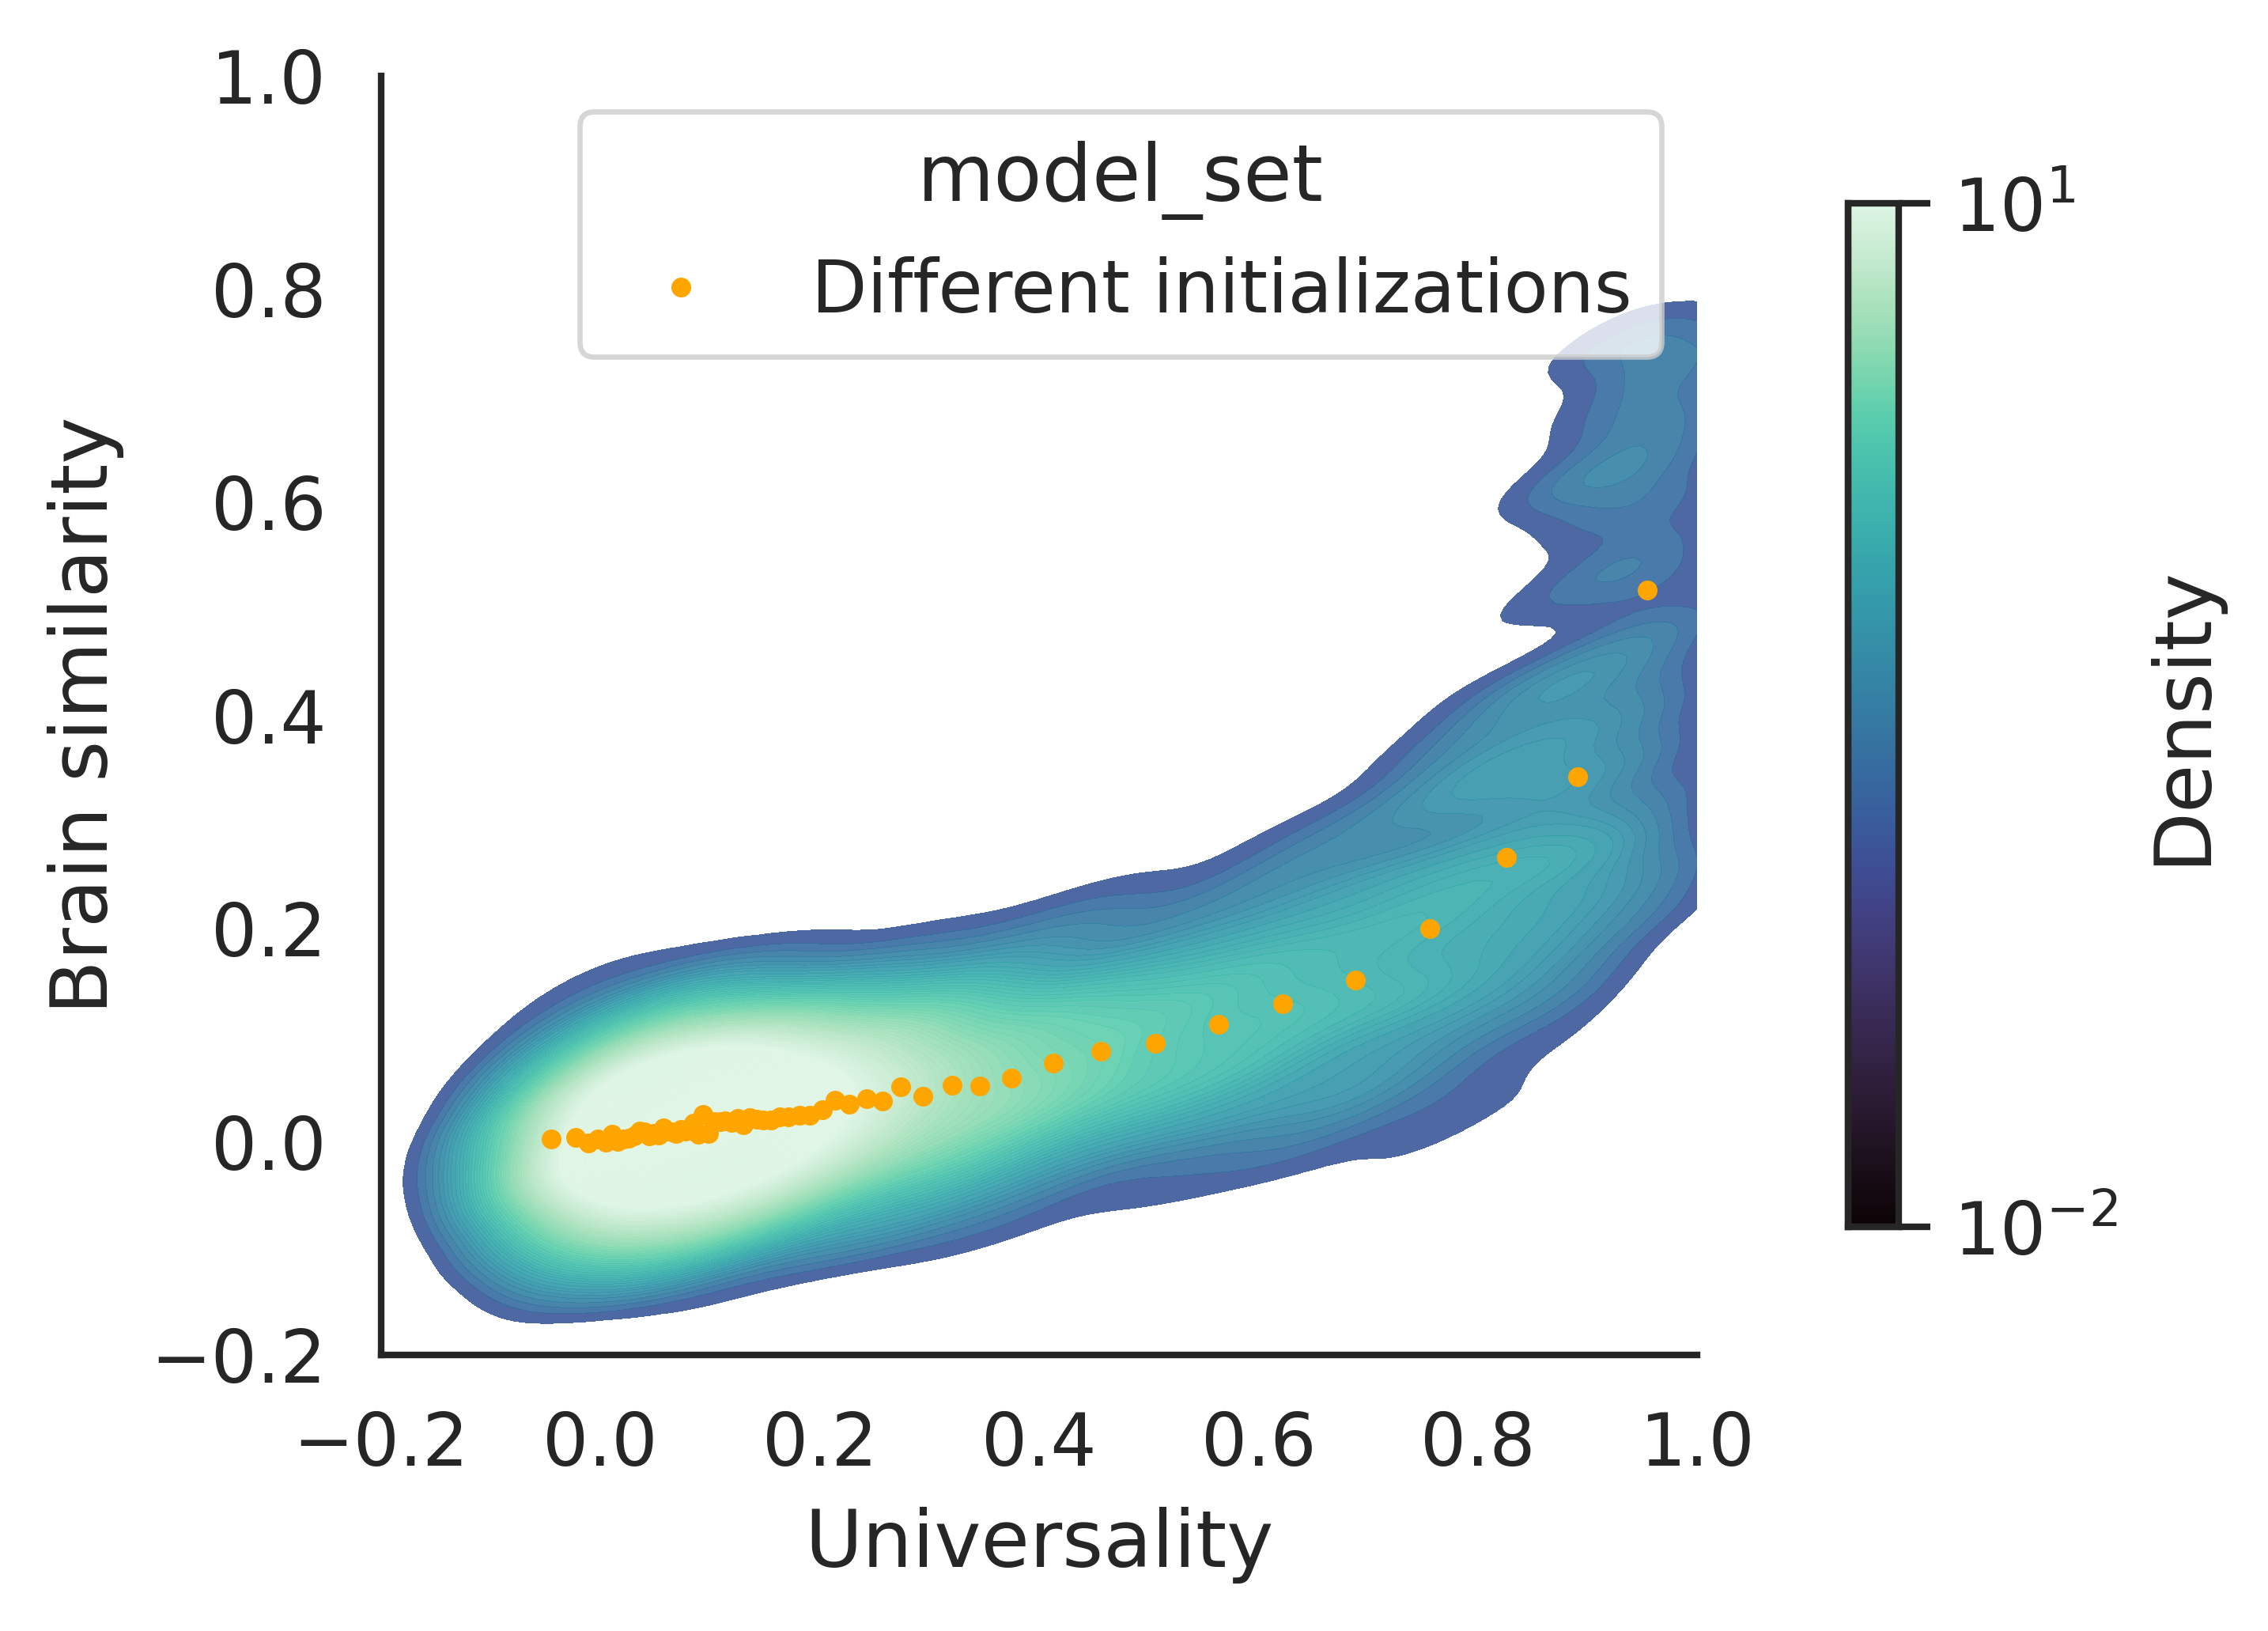

In [9]:
df = _load_main_results(0, "activation_pc", "NSD", roi="general")
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_simple_grid(
        df=df, x="within_basis_ui", y="brain_similarity",
        main_plots=("line", "density",), group="model_set", group_order=_yielder_id(0, label=True),
        xlabel="Universality", ylabel="Brain similarity",
        log_kde=True,
        n_bin=0.01,
        rowcol=(1, 1),
    )

model: 0it [00:00, ?it/s]

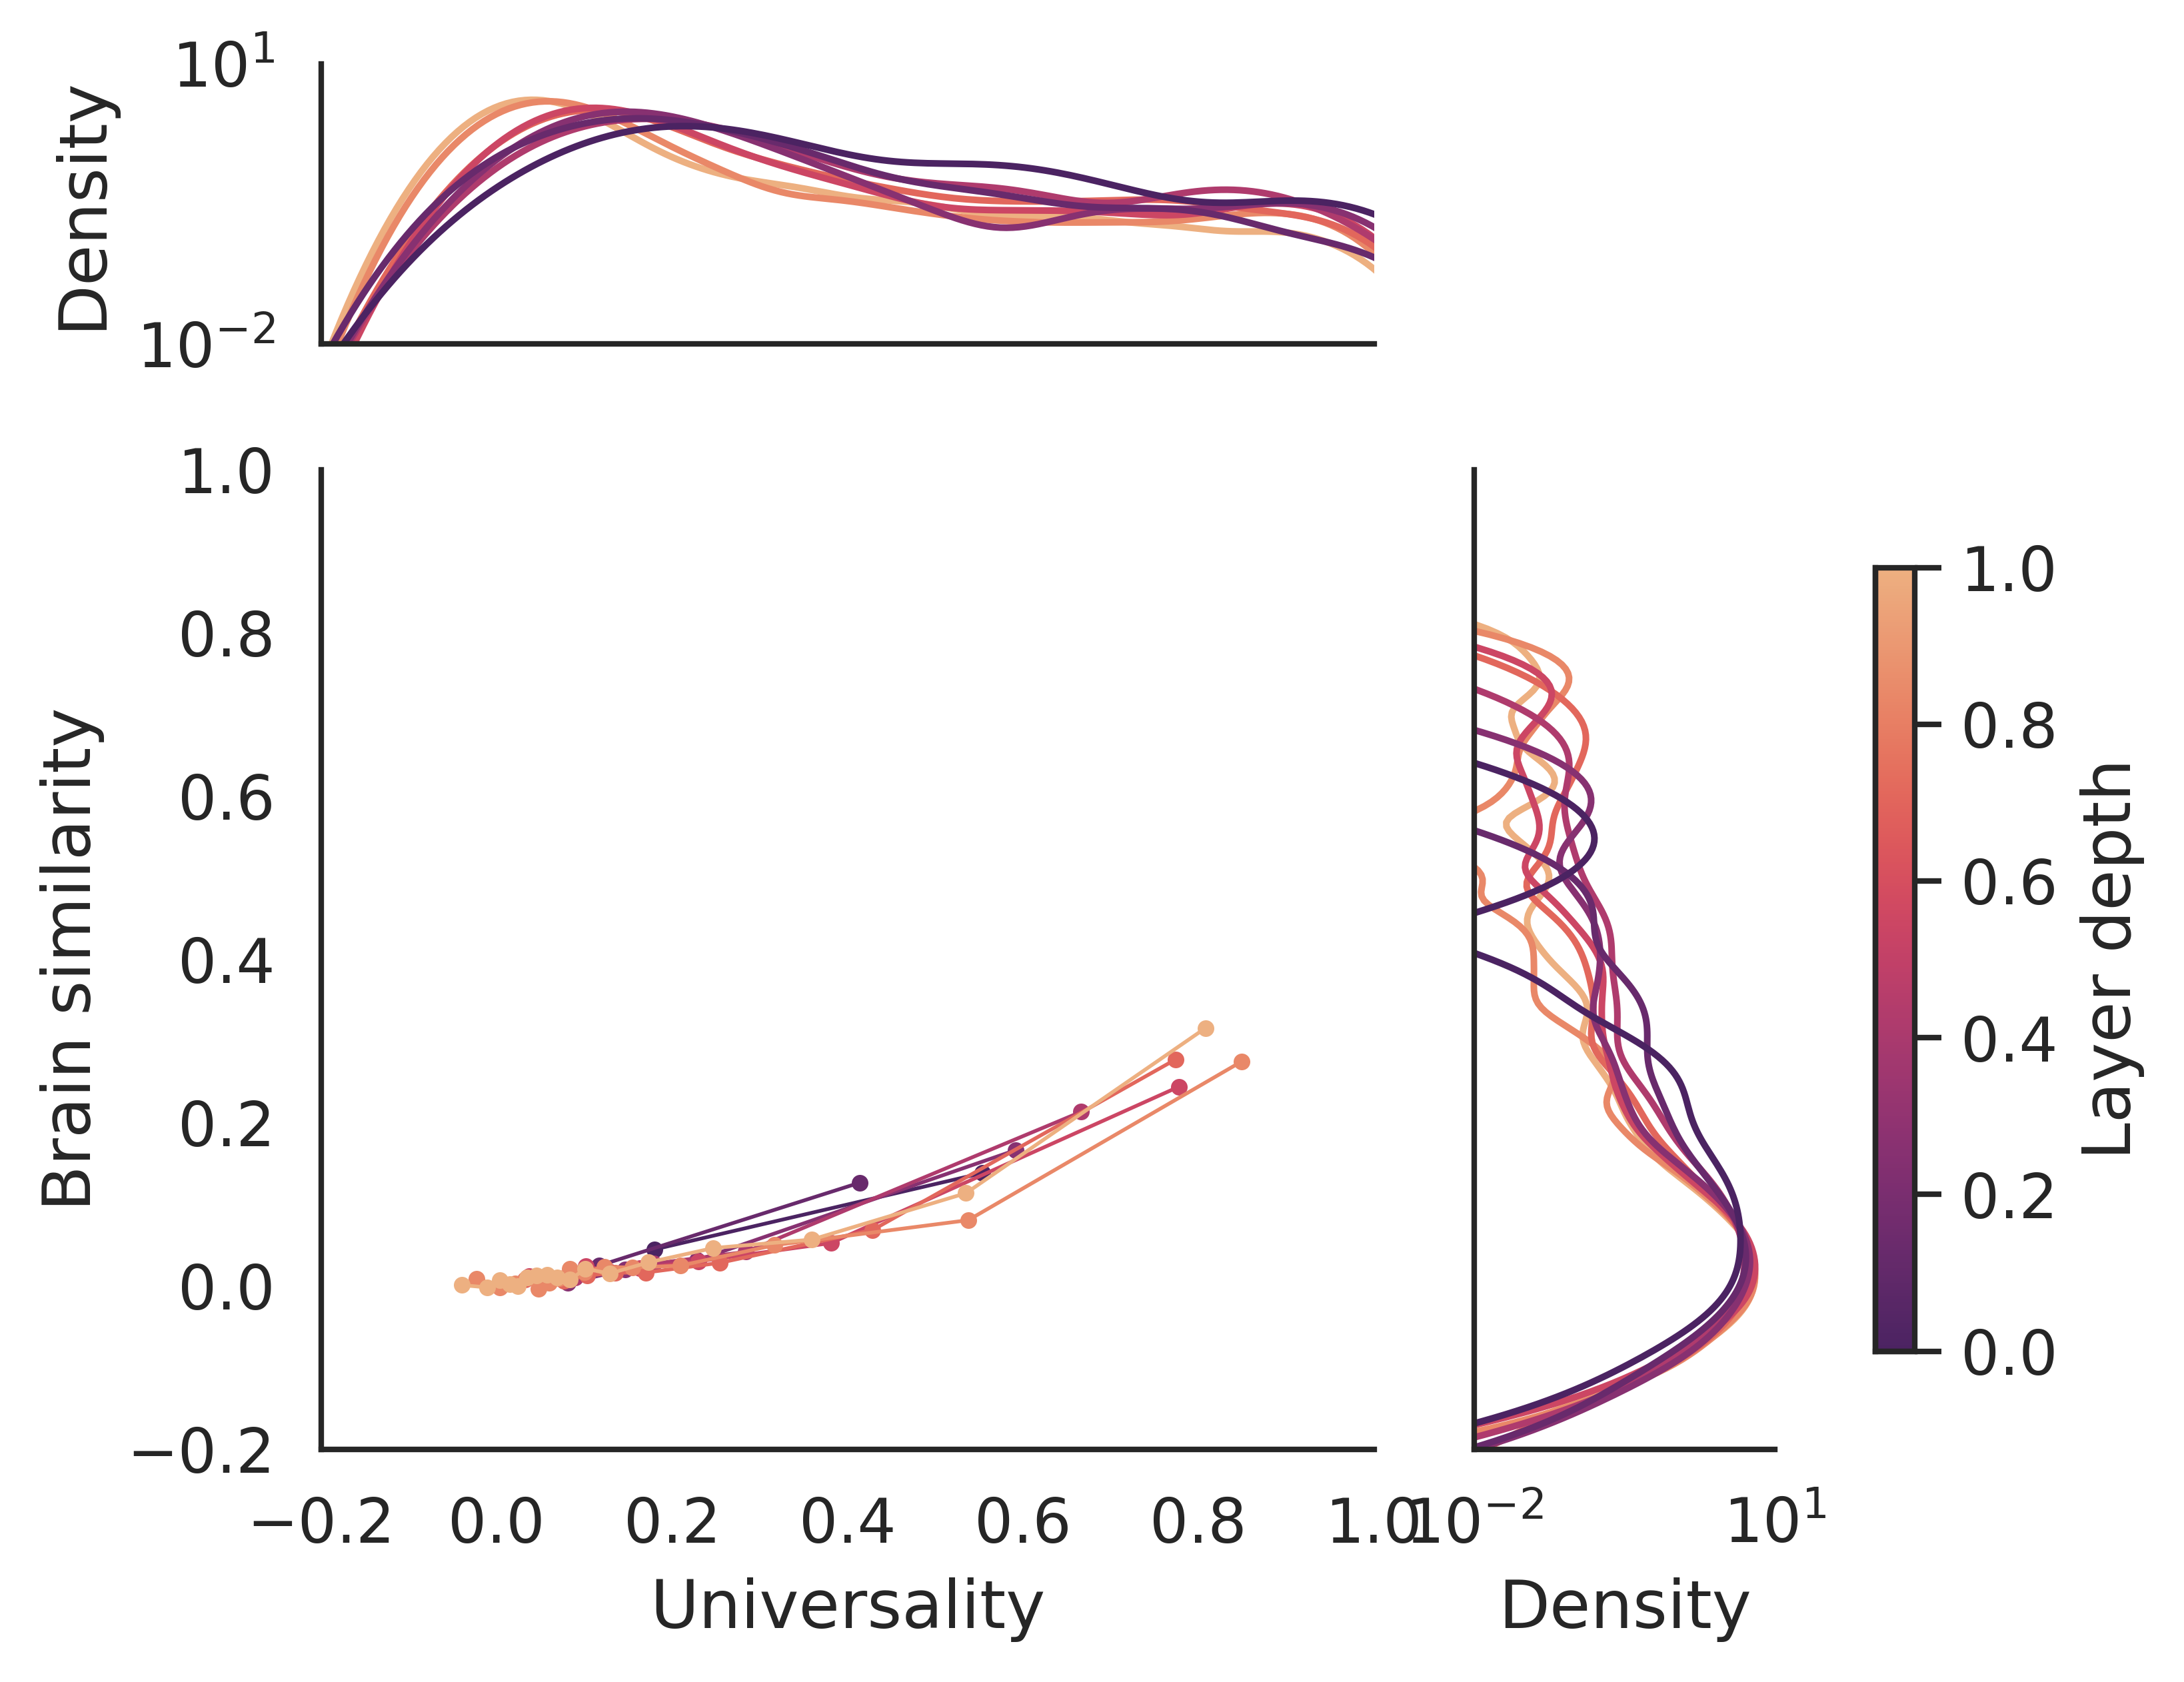

In [12]:
df = _add_node_depths(_load_main_results(0, "activation_pc", "NSD", roi="general"))
df = df_lin_bin(df=df, col="node_depth", label_col="node_depth_bin", level="model_set", n_bin=20,)
with sns.plotting_context("paper", font_scale=1.25,):
    _plot_results_in_grid(
        df=df, x="within_basis_ui", y="brain_similarity",
        main_plots=("line",), group="model_set", group_order=_yielder_id(0, label=True), 
        hue="node_depth_bin", hue_label="Layer depth", palette="flare_r", n_bin=.01,
        xlabel="Universality", ylabel="Brain similarity", 
        log_kde=True,
        rowcol=(1, 1),
    )